<a href="https://colab.research.google.com/github/mra49/Capstone/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
#Load data
df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")

<ipython-input-2-7c7ad50cb670>:4: DtypeWarning: Columns (5,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")


In [3]:
# Convert 'Document Date' to datetime and sort
df['Document Date'] = pd.to_datetime(df['Document Date'], errors='coerce')
df = df.sort_values(by='Document Date')

In [4]:
#Check for missing values
data_types_missing = df.dtypes.to_frame(name='Data Type').join(df.isnull().sum().rename('Missing Value Proportion'))
print(data_types_missing)


                         Data Type  Missing Value Proportion
Location                    object                     12363
Brand                       object                         0
SubBrand                    object                         0
Category                    object                      2592
SOP Number                  object                         0
Item Number                 object                         0
Item Description            object                         0
QTY                          int64                         0
Unit Price                 float64                         0
Extended Price             float64                         0
Customer Number             object                         0
Document Date       datetime64[ns]                         0
Location Code               object                         0
Item Short Name             object                         0
Customer Name               object                         0
SOP Type                

In [5]:
# Statistical summary
statistical_summary = df.describe(include='all', datetime_is_numeric=True)
print(statistical_summary)

       Location   Brand SubBrand       Category         SOP Number  \
count     91216  103579   103579         100987             103579   
unique        7      53       80             20              18383   
top       zone1   style    foamy  Personal Care  inv00000000007055   
freq      42010   42013    39295          56054                 56   
mean        NaN     NaN      NaN            NaN                NaN   
min         NaN     NaN      NaN            NaN                NaN   
25%         NaN     NaN      NaN            NaN                NaN   
50%         NaN     NaN      NaN            NaN                NaN   
75%         NaN     NaN      NaN            NaN                NaN   
max         NaN     NaN      NaN            NaN                NaN   
std         NaN     NaN      NaN            NaN                NaN   

        Item Number       Item Description            QTY     Unit Price  \
count      103579.0                 103579  103579.000000  103579.000000   
unique 

In [6]:
#check for any row with 0 in its quantity because it will affect our work later on
zero_qty_shampoo = df[(df['product_type'] == 'shampoo') & (df['QTY'] == 0)]

if zero_qty_shampoo.empty:
    print("There are no 0 values in 'QTY' for 'shampoo' product_type.")
else:
    print("There are 0 values in 'QTY' for 'shampoo' product_type.")

There are no 0 values in 'QTY' for 'shampoo' product_type.


In [7]:
# Aggregate data by date
daily_data = df.groupby(df['Document Date'].dt.date)['QTY'].sum().reset_index()

In [8]:
#indexing daily_data now again on date
daily_data['Document Date'] = pd.to_datetime(daily_data['Document Date'], errors='coerce')

# xtract the day, month, and year
daily_data['Day'] = daily_data['Document Date'].dt.day
daily_data['Month'] = daily_data['Document Date'].dt.month
daily_data['Year'] = daily_data['Document Date'].dt.year

# Verify the changes
print(daily_data[['Document Date', 'Day', 'Month', 'Year']].head())


  Document Date  Day  Month  Year
0    2020-01-02    2      1  2020
1    2020-01-03    3      1  2020
2    2020-01-04    4      1  2020
3    2020-01-06    6      1  2020
4    2020-01-07    7      1  2020


In [9]:
# Group by 'product_type' and sum 'QTY'
product_type_qty = df.groupby('product_type')['QTY'].sum().reset_index()

# Sort the results for better readability
product_type_qty = product_type_qty.sort_values(by='QTY', ascending=False)

# Display the result
print(product_type_qty.head(13))


          product_type     QTY
184            shampoo  646744
66         dishwashing  335826
130        laundry gel  110892
88     general cleaner   81867
118          hand soap   64482
67        disinfectant   59660
152  multi-use shampoo   49957
77      fabric softner   34251
83       floor cleaner   22988
188         shower gel   17028
4              alcohol   12441
90       glass cleaner   12069
165            oxidant    9833


In [10]:
# Calculate total sales per product (to justify choosing shampoo for forecasting)
total_sales_per_product = df.groupby('product_type')['Extended Price'].sum().reset_index()

# Calculate total sales of all products
total_sales_all_products = total_sales_per_product['Extended Price'].sum()

# Calculate proportion of each product's sales
total_sales_per_product['Sales Proportion'] = total_sales_per_product['Extended Price'] / total_sales_all_products

# Sort the results by 'Extended Price' in descending order
total_sales_per_product = total_sales_per_product.sort_values(by='Extended Price', ascending=False)

# Display the result
print(total_sales_per_product.head(15))


              product_type  Extended Price  Sales Proportion
184                shampoo    1.497706e+07          0.464375
66             dishwashing    6.338873e+06          0.196541
130            laundry gel    3.240409e+06          0.100471
88         general cleaner    1.456768e+06          0.045168
118              hand soap    1.289726e+06          0.039989
77          fabric softner    1.146069e+06          0.035535
67            disinfectant    9.795285e+05          0.030371
152      multi-use shampoo    7.068399e+05          0.021916
83           floor cleaner    6.227723e+05          0.019310
90           glass cleaner    1.625372e+05          0.005040
188             shower gel    1.306650e+05          0.004051
9    anti-dandruff shampoo    8.741831e+04          0.002710
13              antiseptic    8.474707e+04          0.002628
4                  alcohol    8.353710e+04          0.002590
17            baby shampoo    7.019463e+04          0.002176


Not its place
cleaning the product_scent by labeling machine scents as "Not Applicable"

In [11]:
# List of brands for which the product_scent should be 'Not Applicable'
non_scent_brands = ['remington', 'wahl', 'babyliss', 'vitality']

# Replace 'product_scent' with 'Not Applicable' for these brands
df.loc[df['Brand'].str.lower().isin(non_scent_brands), 'product_scent'] = 'Not Applicable'

# Display some of the data to verify the changes
print(df[['Brand', 'product_scent']].head())


        Brand   product_scent
0   remington  Not Applicable
61      style      cool ocean
60      style             NaN
59      style             NaN
58      style             NaN


In [12]:
# Data types and missing values
data_types_missing = df.dtypes.to_frame(name='Data Type').join(df.isnull().sum().rename('Missing Value Proportion'))
print(data_types_missing)


                         Data Type  Missing Value Proportion
Location                    object                     12363
Brand                       object                         0
SubBrand                    object                         0
Category                    object                      2592
SOP Number                  object                         0
Item Number                 object                         0
Item Description            object                         0
QTY                          int64                         0
Unit Price                 float64                         0
Extended Price             float64                         0
Customer Number             object                         0
Document Date       datetime64[ns]                         0
Location Code               object                         0
Item Short Name             object                         0
Customer Name               object                         0
SOP Type                

###Add neutral to scentless shampoo's (might be used later for LSTM forecasting)

In [13]:
import pandas as pd

# Assuming df is your DataFrame

# Filter to select rows where 'product_type' is 'shampoo' and 'product_scent' is null
shampoo_with_null_scent = df[(df['product_type'] == 'shampoo') & (df['product_scent'].isnull())]

# Get the count of these rows
count_shampoo_with_null_scent = len(shampoo_with_null_scent)

# Display the count
print("Count of shampoo products with null scent:", count_shampoo_with_null_scent)


Count of shampoo products with null scent: 3717


In [14]:
# Replace null values in 'product_scent' with 'Neutral' for 'shampoo' product_type
df.loc[(df['product_type'] == 'shampoo') & (df['product_scent'].isnull()), 'product_scent'] = 'Neutral'

# Verify the changes (optional)
print(df[df['product_type'] == 'shampoo'][['product_type', 'product_scent']].head())

   product_type product_scent
61      shampoo    cool ocean
60      shampoo       Neutral
59      shampoo       Neutral
57      shampoo       Neutral
62      shampoo     m.islands


should be at the top, out of its place here

###Replace Item Number values with those in Unified IN and delete the latter

In [15]:
import pandas as pd

# Assuming df is your DataFrame

# Replace 'Item Number' with values from 'Unique IN'
df['Item Number'] = df['Unified IN']

# Drop the 'Unique IN' column
df.drop(columns=['Unified IN'], inplace=True)

# Drop columns with no variation
for column in df.columns:
    if df[column].nunique() == 1:
        df.drop(columns=[column], inplace=True)

In [16]:
###########  Genral Cleaning   ############
# Update 'With Offer' based on 'Item Description' containing '+' or '*'
df['With Offer'] = df['Item Description'].apply(lambda x: 1 if ('+' in x or '*' in x) else 0)

# Verify the changes (optional)
print(df[['Item Description', 'With Offer']].head())

                  Item Description  With Offer
0   rem s1a100 my stylist straight           0
61   style cool ocean shampoo 2250           0
60          style shanpoo 1.125l*3           1
59          style shanpoo 1.125l*3           1
58  style bone marrow conditioning           0


In [17]:
# Count the occurrences of each value in the 'With Offer' column
offer_counts = df['With Offer'].value_counts()

# Display the counts
print(offer_counts)

0    98460
1     5119
Name: With Offer, dtype: int64


size cleaning also useful for shampoo correct place

In [18]:
import pandas as pd

# Assuming df is your DataFrame

# Define a function to update product_size based on SubBrand
def update_product_size(row):
    if row['SubBrand'] == 'sh4000+s':
        return '4L'
    elif row['SubBrand'] == 'sh2250+s':  # Example condition
        return '2.25L'
    elif row['SubBrand'] == 'sh1125+s':  # Another example condition
        return '1.125L'
    # Add more conditions as needed
    else:
        return row['product_size']  # Keep the original size if none of the conditions are met

# Apply the function to update the product_size column
df['product_size'] = df.apply(update_product_size, axis=1)

In [19]:
import re
# Function to convert and standardize product size
def standardize_product_size(size):
    # Convert to string, handle None, and strip whitespace
    size_str = str(size).strip() if size is not None else ''

    # # Debug: Print the original size string
    # print("Original:", size_str)

    # Extract numeric part and unit
    numeric_part = re.sub('[^0-9.]', '', size_str)
    unit = re.sub('[0-9.]', '', size_str).lower()

    # Convert the numeric part to float
    numeric_size = float(numeric_part) if numeric_part else 0

    # Convert 'ml' or 'm' to liters
    if 'ml' in unit or 'm' in unit:
        result = f"{numeric_size / 1000}L"
    elif 'l' in unit:
        result = f"{numeric_size}L"
    elif unit == '' and numeric_size > 12:
        result = f"{numeric_size / 1000}L"
    elif unit == '':
        result = f"{numeric_size}L"
    else:
        result = f"{numeric_size}{unit}"

    # # Debug: Print the final result
    # print("Converted:", result)

    return result

# Apply the function to the 'product_size' column
df['product_size'] = df['product_size'].apply(standardize_product_size)

# Verify the changes
print(df[['Item Description', 'product_size']].head(5))


                  Item Description product_size
0   rem s1a100 my stylist straight         0nan
61   style cool ocean shampoo 2250        2.25L
60          style shanpoo 1.125l*3       1.125L
59          style shanpoo 1.125l*3       1.125L
58  style bone marrow conditioning         0nan


In [20]:
df['product_size'] = df['product_size'].replace('0.0nan', np.nan)

In [21]:
# Group by 'Item Number' and filter out those that appear less than 10 times, then overwrite df
df = df.groupby('Item Number').filter(lambda x: len(x) >= 10)

In [22]:
######### TRIM df to SHAMPOO  ##########
import pandas as pd

# Assuming df is your DataFrame

# Filter the DataFrame for 'shampoo' product_type
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the missing 'product_size' values
missing_sizes_count = shampoo_df['product_size'].isnull().sum()
missing_location_count = shampoo_df['Location ID'].isnull().sum()
# Display the count
print(f"Number of missing size values for shampoo product_type: {missing_sizes_count}")
print(f"Number of missing location values for shampoo product_type: {missing_location_count}")

Number of missing size values for shampoo product_type: 0
Number of missing location values for shampoo product_type: 5458


In [23]:
distinct_sizes = shampoo_df['product_size'].unique()

print("Distinct product sizes for 'shampoo':", distinct_sizes)

Distinct product sizes for 'shampoo': ['2.25L' '1.125L' '0.5L' '4.0L' '0nan' '6.0L' '1.5L' '3.0L' '10.0L'
 '0.008L' '4.2L' '2.0L' '0.4L' '0.04L' '2.2L']


In [24]:
print(df['product_size'].head(20))

61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56     0.03L
47     0.02L
46    0.055L
45      0nan
62     2.25L
63     2.25L
64     2.25L
65      4.0L
84     2.25L
83      4.0L
82     2.25L
81     2.25L
80     2.25L
78      4.0L
77      4.0L
Name: product_size, dtype: object


In [25]:
import numpy as np

# Define your conditions and corresponding choices
conditions = [
    df['SubBrand'] == 'sh4000+s',
    df['SubBrand'] == 'sh2250+s',
    df['SubBrand'] == 'sh1125+s'
    # Add more conditions here
]

choices = [
    '4L',
    '2.25L',
    '1.125L'
    # Add corresponding choices for each condition
]

# Apply the conditions and choices
df['product_size'] = np.select(conditions, choices, default=df['product_size'])

# Display the updated DataFrame
print(df['product_size'].head(20))


61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56     0.03L
47     0.02L
46    0.055L
45      0nan
62     2.25L
63     2.25L
64     2.25L
65        4L
84     2.25L
83        4L
82     2.25L
81     2.25L
80     2.25L
78        4L
77        4L
Name: product_size, dtype: object


In [26]:
import pandas as pd

# Original size_mapping
size_mapping = {
    "1.125L": ['0.0112L','1.5L', '0.112L','11.0L','10L','10.0L'],
    "2.25L": ['0.022L','0.225L','0.02L'],
    "4.0L": ['0.4L','0.04L','4.2L']
}

# Invert the size_mapping dictionary
inverted_size_mapping = {old_size: new_size for new_size, old_sizes in size_mapping.items() for old_size in old_sizes}

# Use map with the inverted dictionary to update the product_size column
# Retain original values where there's no mapping found
df['product_size'] = df['product_size'].map(inverted_size_mapping).fillna(df['product_size'])

# Display the updated DataFrame
print(df['product_size'].head(20))


61     2.25L
60    1.125L
59    1.125L
58      0nan
57      0.5L
56     0.03L
47     2.25L
46    0.055L
45      0nan
62     2.25L
63     2.25L
64     2.25L
65        4L
84     2.25L
83        4L
82     2.25L
81     2.25L
80     2.25L
78        4L
77        4L
Name: product_size, dtype: object


In [27]:
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the number of shampoos for each size
shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

print("Count of shampoos for each size:")
print(shampoo_counts_by_size)

Count of shampoos for each size:
1.125L    13366
2.25L     12880
4L        12733
3.0L       2800
6.0L       2343
4.0L        608
0nan        337
2.2L         68
0.008L       46
0.5L         31
2.0L         25
Name: product_size, dtype: int64


The plan is to create a reference DataFrame that maps each unique customer number to its corresponding location (using the first location that appears for each customer number). Then, we will use this mapping to fill in missing location values in your original DataFrame.

In [28]:
# Create a reference DataFrame with unique customer numbers and their first corresponding location
ref_df = df.dropna(subset=['Location ID', 'Customer Number'])\
           .drop_duplicates(subset='Customer Number')\
           [['Customer Number', 'Location ID']]

print(ref_df.head())  # Just to check the reference DataFrame

   Customer Number   Location ID
61      000c004280     sprvsrsth
58      000c000007  intercompany
84      000c029866     sprvsrbek
76      000c025095        slska1
18      000c023682       slssth2


In [29]:
# Function to fill missing locations based on the customer number
def fill_missing_location(row):
    if pd.isna(row['Location ID']) and row['Customer Number'] in ref_df['Customer Number'].values:
        return ref_df[ref_df['Customer Number'] == row['Customer Number']]['Location ID'].values[0]
    else:
        return row['Location ID']

# Apply the function to fill missing 'Location ID'
df['Location ID'] = df.apply(fill_missing_location, axis=1)

In [30]:
missing_location_count = shampoo_df['Location ID'].isnull().sum()
print(f"Number of missing size values for shampoo product_type: {missing_location_count}")

Number of missing size values for shampoo product_type: 5458


In [31]:
# Rename 'QTY' to 'Old QTY'
df.rename(columns={'QTY': 'Old QTY'}, inplace=True)

# Function to extract the numeric part from the 'product_size' string
def extract_size(size_str):
    if pd.isna(size_str):
        return 1  # Return 1 if size_str is NaN or None
    # Extract numbers from the string and convert to float
    return float(''.join(filter(lambda x: x.isdigit() or x == '.', size_str)))

# Apply the function to create a new column with numeric sizes
df['Numeric Size'] = df['product_size'].apply(extract_size)

# Create a new 'QTY' column by multiplying 'Old QTY' by 'Numeric Size'
df['QTY'] = df['Old QTY'] * df['Numeric Size']

# Optionally, you can drop the 'Numeric Size' column if it's no longer needed
df.drop('Numeric Size', axis=1, inplace=True)

# Display the updated DataFrame
print(df)

       Location   Brand    SubBrand            Category         SOP Number  \
61        zone1   style    sh2250+s       Personal Care  inv00000000005717   
60        zone1   style    sh1125+s       Personal Care  inv00000000005717   
59        zone1   style    sh1125+s       Personal Care  inv00000000005717   
58        zone1   style       style       Personal Care  inv00000000005716   
57        zone1  Keplex  profession       Personal Care  inv00000000005716   
...         ...     ...         ...                 ...                ...   
103514    zone3   style    sh2250+s       Personal Care  inv00000000025343   
103513    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103512    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103510    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103578    zone3   foamy       foamy  Household Cleaning  inv00000000025353   

       Item Number                Item Description  Old QTY  Un

In [32]:
######### TRIM df to SHAMPOO  ##########
import pandas as pd

# Assuming df is your DataFrame

# Filter the DataFrame for 'shampoo' product_type
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the missing 'product_size' values
missing_sizes_count = shampoo_df['product_size'].isnull().sum()
missing_location_count = shampoo_df['Location ID'].isnull().sum()
# Display the count
print(f"Number of missing size values for shampoo product_type: {missing_sizes_count}")
print(f"Number of missing location values for shampoo product_type: {missing_location_count}")

Number of missing size values for shampoo product_type: 0
Number of missing location values for shampoo product_type: 410


In [33]:
shampoo_df.columns

Index(['Location', 'Brand', 'SubBrand', 'Category', 'SOP Number',
       'Item Number', 'Item Description', 'Old QTY', 'Unit Price',
       'Extended Price', 'Customer Number', 'Document Date', 'Item Short Name',
       'Customer Name', 'Location ID', 'Offer Status', 'product_type',
       'product_scent', 'product_size', 'Description Length', 'Subcategory',
       'With Offer', 'QTY'],
      dtype='object')

Checking for Outliers

In [34]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, outliers.shape[0], outliers.describe()

In [35]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
outliers_qty, count_qty, description_qty = detect_outliers_iqr(shampoo_df, 'QTY')

# Display the count and summary of outliers
print(f"Count of Outliers in QTY: {count_qty}")
print("Outlier Summary for QTY:")
print(description_qty)

Count of Outliers in QTY: 5671
Outlier Summary for QTY:
           Old QTY   Unit Price  Extended Price  Description Length  \
count  5671.000000  5671.000000     5671.000000         5671.000000   
mean     60.956621    26.518731     1204.289564           29.087110   
std      53.716536    30.245224     1124.335538            3.642609   
min      12.000000     0.000000        0.000000           21.000000   
25%      24.000000     9.773000      438.095000           29.000000   
50%      40.000000    17.204000      859.248000           30.000000   
75%      75.000000    26.210000     1624.200000           30.000000   
max     336.000000   243.449000     4915.404000           41.000000   

        With Offer          QTY  
count  5671.000000  5671.000000  
mean      0.024158   185.406837  
std       0.153553   165.557727  
min       0.000000    72.000000  
25%       0.000000    91.125000  
50%       0.000000   128.000000  
75%       0.000000   208.000000  
max       1.000000  1800.000000 

checking for extreme outliers

In [36]:
def detect_extreme_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 30 * IQR

    extreme_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return extreme_outliers

In [37]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
extreme_outliers_qty = detect_extreme_outliers_iqr(shampoo_df, 'QTY')

# Sort the extreme outliers by 'QTY'
extreme_outliers_qty_sorted = extreme_outliers_qty.sort_values(by='QTY')

# Display only the 'QTY' and 'Item Description' columns
print(extreme_outliers_qty_sorted[['Item Description', 'QTY']])

                      Item Description     QTY
103498  style shampoo  apricot & peach   800.0
28442   style apple blossom sh. 4000ml   800.0
23033    style shampoo meridian 4000ml   800.0
21517   style apple blossom sh. 4000ml   800.0
21518    style shampoo meridian 4000ml   800.0
...                                ...     ...
3989            x-pert shampoo rose 6l  1800.0
11094           x-pert shampoo rose 6l  1800.0
13681           x-pert shampoo rose 6l  1800.0
4259            x-pert shampoo rose 6l  1800.0
7207            x-pert shampoo rose 6l  1800.0

[96 rows x 2 columns]


##ARIMA

In [38]:
# Check for missing values in the relevant columns for ARIMA
missing_values_qty = df['QTY'].isnull().sum()
missing_values_date = df['Document Date'].isnull().sum()

# Display the counts of missing values
print(f"Missing Values in 'QTY': {missing_values_qty}")
print(f"Missing Values in 'Document Date': {missing_values_date}")

Missing Values in 'QTY': 0
Missing Values in 'Document Date': 0


###Index by date

In [39]:
shampoo_daily = shampoo_df.groupby(shampoo_df['Document Date'].dt.date)['QTY'].sum()

In [40]:
shampoo_daily.index = pd.to_datetime(shampoo_daily.index)
shampoo_daily = shampoo_daily.sort_index()

###Plot the qty vs time and the ACF & PACF for it

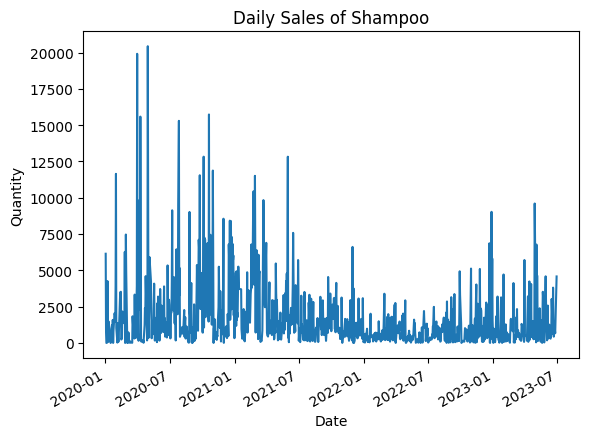

In [41]:
import matplotlib.pyplot as plt

shampoo_daily.plot()
plt.title('Daily Sales of Shampoo')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

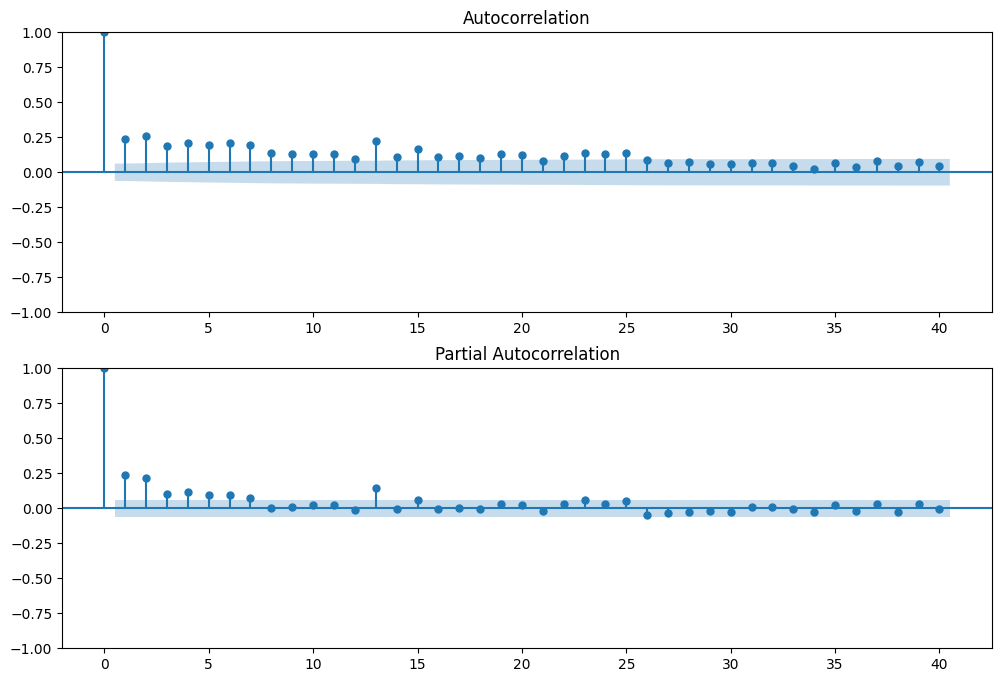

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming shampoo_daily is your original time series
# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# ACF plot
plot_acf(shampoo_daily, lags=40, ax=ax1)  # Adjust lags as necessary

# PACF plot
plot_pacf(shampoo_daily, lags=40, method='ywm', ax=ax2)  # Adjust lags as necessary

plt.show()

In [43]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(shampoo_daily)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.129601
p-value: 0.000012


GPT
The ADF (Augmented Dickey-Fuller) test results indicate that the time series is stationary. Here's why:

ADF Statistic: A value of -5.147788 is more negative than typical critical values for stationarity (which might range from -2.5 to -3.5 depending on the dataset size and selected confidence level). This suggests that the null hypothesis of a unit root (non-stationarity) can be rejected.

p-value: A p-value of 0.000011 is well below the common alpha level of 0.05. This indicates strong evidence against the null hypothesis, so you can conclude that the time series does not have a unit root and is stationary.

Since the time series is stationary, you can proceed with building an ARIMA model without the need for differencing (d=0). The next steps involve determining the (p) and (q) parameters of the ARIMA model, which represent the order of the autoregressive terms and the order of the moving average terms, respectively.

###Run the first simple arima model & diagnostics after confirming stationary

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


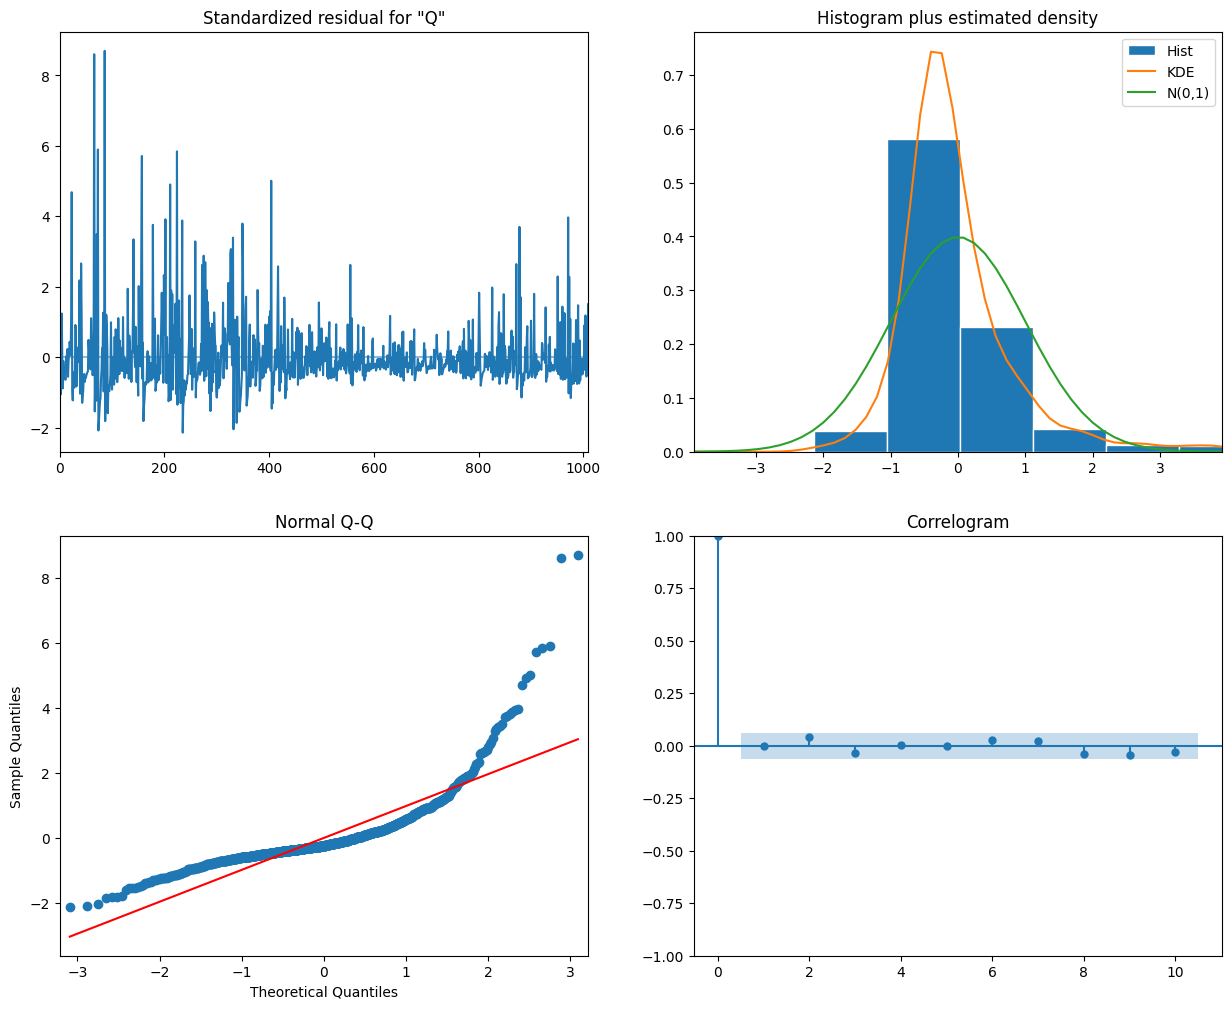

1010    1782.333328
1011    1777.988108
1012    1773.841654
1013    1769.884873
1014    1766.109089
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [44]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARIMA model (example with order (1,0,1))
model = ARIMA(shampoo_daily, order=(1, 0, 1))
model_fit = model.fit()

# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make Forecast
forecast = model_fit.forecast(steps=5)  # Forecast next 5 periods
print(forecast)

###Plot ACF PACF for the model

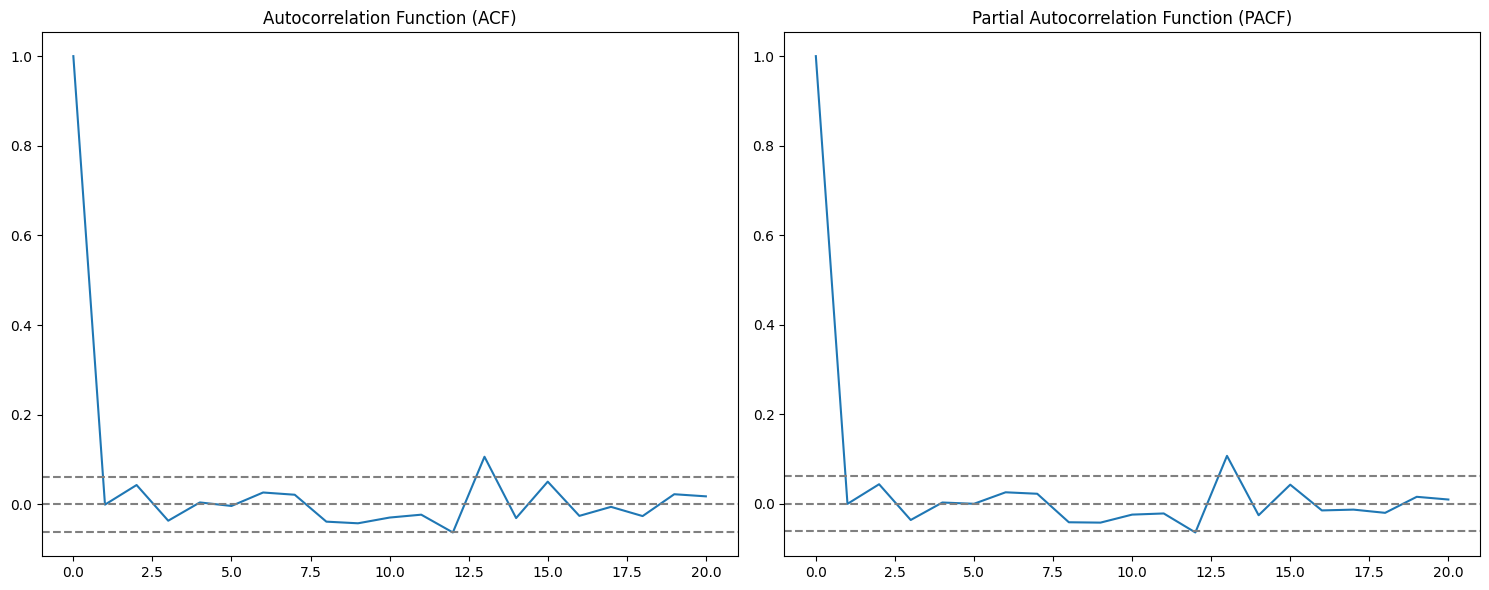

In [45]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate the ACF and PACF
lag_acf = acf(model_fit.resid, nlags=20)
lag_pacf = pacf(model_fit.resid, nlags=20, method='ols')

# Plot ACF and PACF
plt.figure(figsize=(15, 6))

# ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [46]:
 pip install pmdarima

###Using auto_arima to obtain perfect parameters

In [47]:
from pmdarima import auto_arima
import pandas as pd

# Assuming shampoo_daily is your time series DataFrame for 'shampoo' product_type

# Running auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(shampoo_daily, start_p=0, start_q=0,
                              test='adf',       # Use adftest to find optimal 'd'
                              max_p=5, max_q=5, # Maximum p and q
                              m=1,              # Frequency of the series
                              d=None,           # Let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18907.327, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18601.377, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18736.341, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=18465.093, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=18428.757, Time=0.30 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=18395.388, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=18376.006, Time=0.57 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=18311.895, Time=3.05 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=18315.050, Time=1.83 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=18314.142, Time=4.24 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=18312.518, Time=2.78 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=18328.797, Time=2.45 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0]          
Total fit time: 16.594 seconds
                               SARIMAX Results                             

###fitting model and diagnostics for auto arima results

In [48]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model without the non-significant term
model = ARIMA(shampoo_daily, order=(2, 0, 2))
model_fit = model.fit()

# Display the model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -9148.942
Date:                Thu, 07 Dec 2023   AIC                          18309.883
Time:                        12:12:18   BIC                          18339.390
Sample:                             0   HQIC                         18321.092
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1687.3426    373.182      4.522      0.000     955.920    2418.766
ar.L1         -0.0165      0.041     -0.404      0.686      -0.096       0.063
ar.L2          0.9280      0.042     22.016      0.0

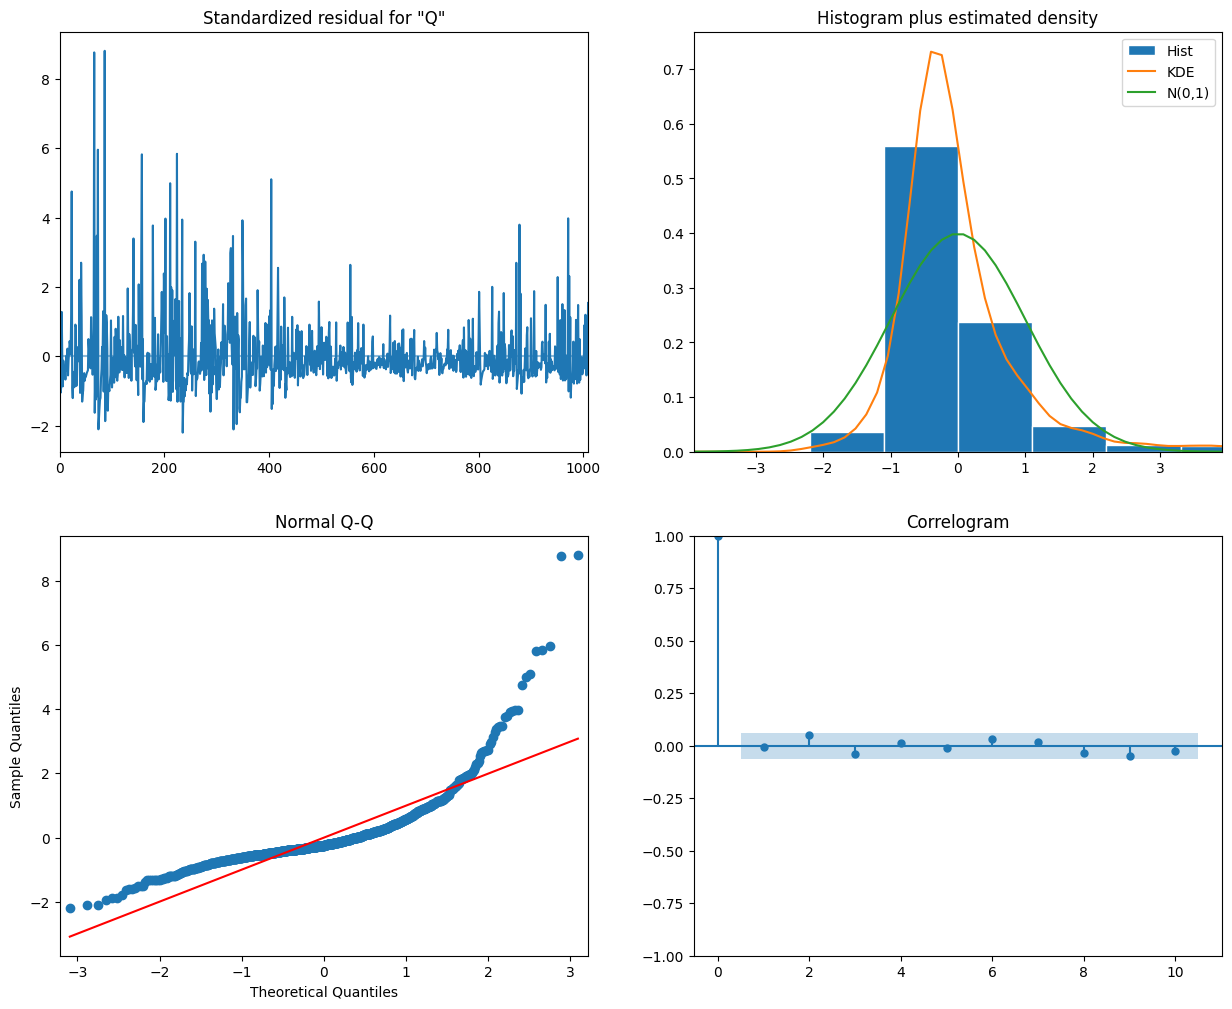

In [49]:
# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

###fitting auto arima model by removing outliers (using the residuals)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8838.128
Date:                Thu, 07 Dec 2023   AIC                          17690.257
Time:                        12:12:22   BIC                          17724.681
Sample:                             0   HQIC                         17703.334
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1474.7062    231.631      6.367      0.000    1020.718    1928.694
Outlier     1.074e+04    155.936     68.862      0.000    1.04e+04     1.1e+04
ar.L1          0.0912      0.438      0.208      0.8

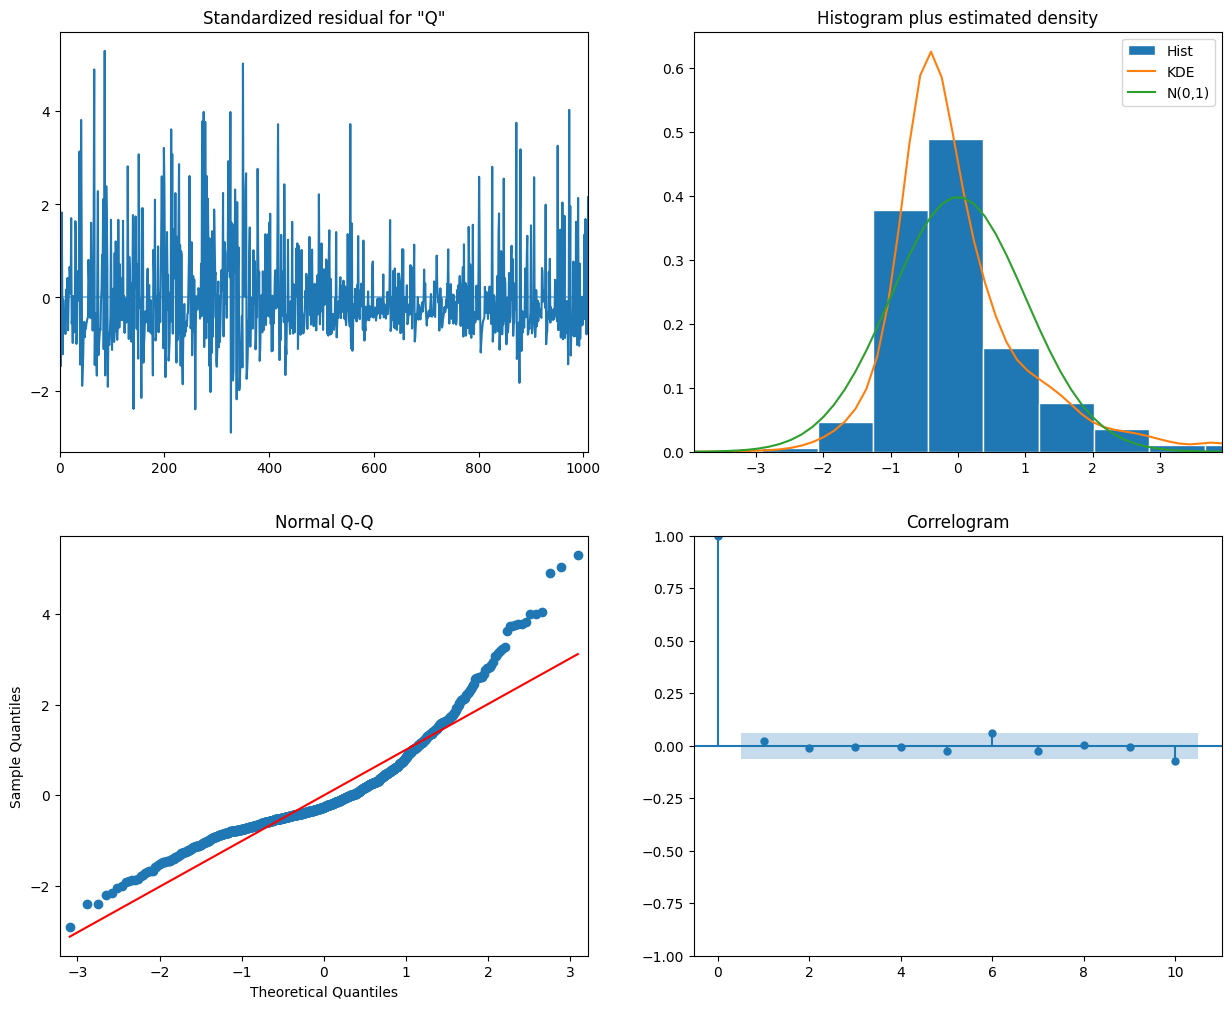

In [50]:
# Assuming 'shampoo_daily' is your Pandas Series of summed 'QTY'
shampoo_daily_df = shampoo_daily.to_frame(name='QTY')

# Ensure that 'QTY' is numeric and has no missing values
shampoo_daily_df['QTY'] = pd.to_numeric(shampoo_daily_df['QTY'], errors='coerce').fillna(0)

# Calculate the standard deviation of the residuals
residuals_std = np.std(model_fit.resid)

# Generate a boolean Series for outliers from the residuals
is_outlier = (model_fit.resid > 3 * residuals_std) | (model_fit.resid < -3 * residuals_std)

# Ensure the boolean Series for outliers is aligned with the shampoo_daily_df index
# The residuals are aligned with the model's fitted values, which correspond to the original Series' index
is_outlier_aligned = pd.Series(is_outlier, index=shampoo_daily_df.index)

# Fill NaN values with 0 for the outlier column
is_outlier_aligned_filled = is_outlier_aligned.fillna(0)

# Add the outlier information as a new column in the DataFrame
shampoo_daily_df['Outlier'] = is_outlier_aligned_filled.astype(int)

# Fit the ARIMA model with the 'Outlier' column as an exogenous variable
model_with_dummy = ARIMA(shampoo_daily_df['QTY'], exog=shampoo_daily_df[['Outlier']], order=(2, 0, 2))
model_with_dummy_fit = model_with_dummy.fit()

# Print the summary of the new model
print(model_with_dummy_fit.summary())

# Plot the diagnostics for the new model
model_with_dummy_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


###building the auto arima model using the boxcox method for outliers

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


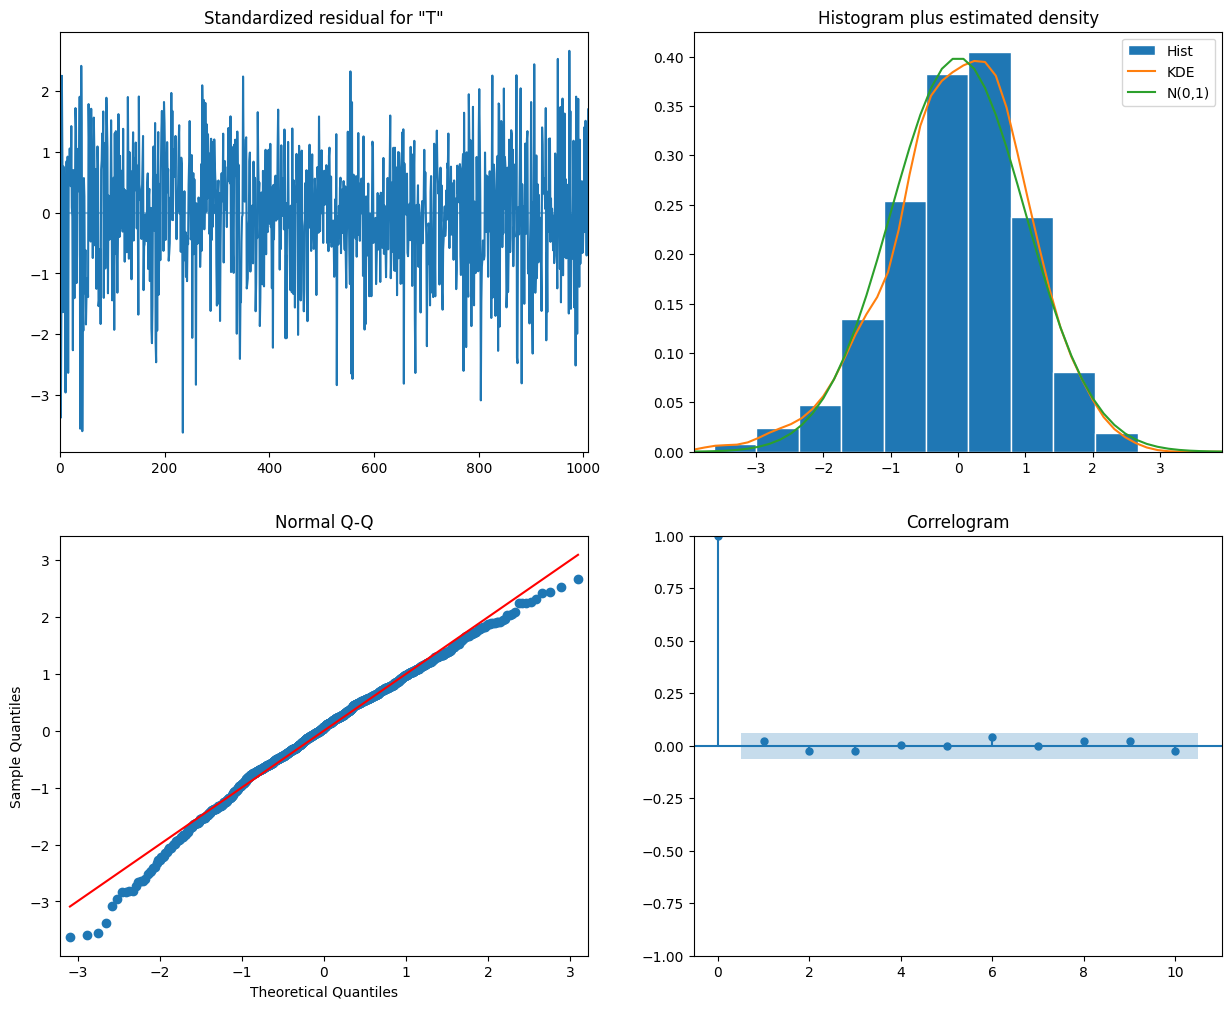

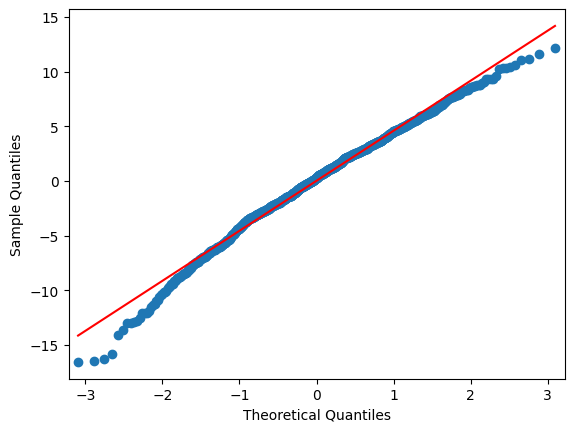

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Ensure all values are positive for Box-Cox Transformation
constant_to_add = abs(min(shampoo_daily_df['QTY'])) + 1
shampoo_daily_positive = shampoo_daily_df['QTY'] + constant_to_add

# Apply Box-Cox Transformation to the positive values
shampoo_daily_transformed, lambda_value = boxcox(shampoo_daily_positive)

# Create a new DataFrame for modeling which aligns the transformed data with the exogenous variable
modeling_df = pd.DataFrame({
    'Transformed_QTY': shampoo_daily_transformed,
    'Outlier': shampoo_daily_df['Outlier']
})

# Fit the ARIMA model on the transformed data
model_with_dummy_transformed = ARIMA(modeling_df['Transformed_QTY'], exog=modeling_df['Outlier'], order=(2, 0, 2))
model_with_dummy_fit_transformed = model_with_dummy_transformed.fit()

# Plot the diagnostics for the new model
model_with_dummy_fit_transformed.plot_diagnostics(figsize=(15, 12))
plt.show()

# Use qqplot to check normality visually
qqplot(model_with_dummy_fit_transformed.resid, line='s')
plt.show()


###Evaluating the model

In [52]:
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
import numpy as np

split_date = pd.to_datetime('2022-01-01')


train_data_transformed = modeling_df[modeling_df.index <= split_date]
test_data_transformed = modeling_df[modeling_df.index > split_date]

# Fit the ARIMA model on the transformed train data
train_model_transformed = ARIMA(train_data_transformed['Transformed_QTY'], exog=train_data_transformed['Outlier'], order=(2, 0, 2))
train_model_fit_transformed = train_model_transformed.fit()

# Forecast on the transformed test data
forecast_transformed = train_model_fit_transformed.forecast(steps=len(test_data_transformed), exog=test_data_transformed['Outlier'])

# Inverse Box-Cox Transformation on forecast and actual test data
forecast_original_scale = inv_boxcox(forecast_transformed, lambda_value)
actual_original_scale = inv_boxcox(test_data_transformed['Transformed_QTY'], lambda_value)

# Calculate RMSE
mse = mean_squared_error(actual_original_scale, forecast_original_scale)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Test RMSE: 1136.366


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [53]:
# Calculate the mean of the original sales data
mean_original_data = shampoo_daily_df['QTY'].mean()
print(f'Mean of Original Sales Data: {mean_original_data:.3f}')

Mean of Original Sales Data: 1687.342


###Trying for Covid

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  717
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6257.188
Date:                Thu, 07 Dec 2023   AIC                          12526.376
Time:                        12:12:38   BIC                          12553.826
Sample:                             0   HQIC                         12536.975
                                - 717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1355.7729    346.503      3.913      0.000     676.640    2034.906
ar.L1          0.2003      0.262      0.764      0.445      -0.314       0.714
ar.L2          0.7246      0.252      2.880      0.0

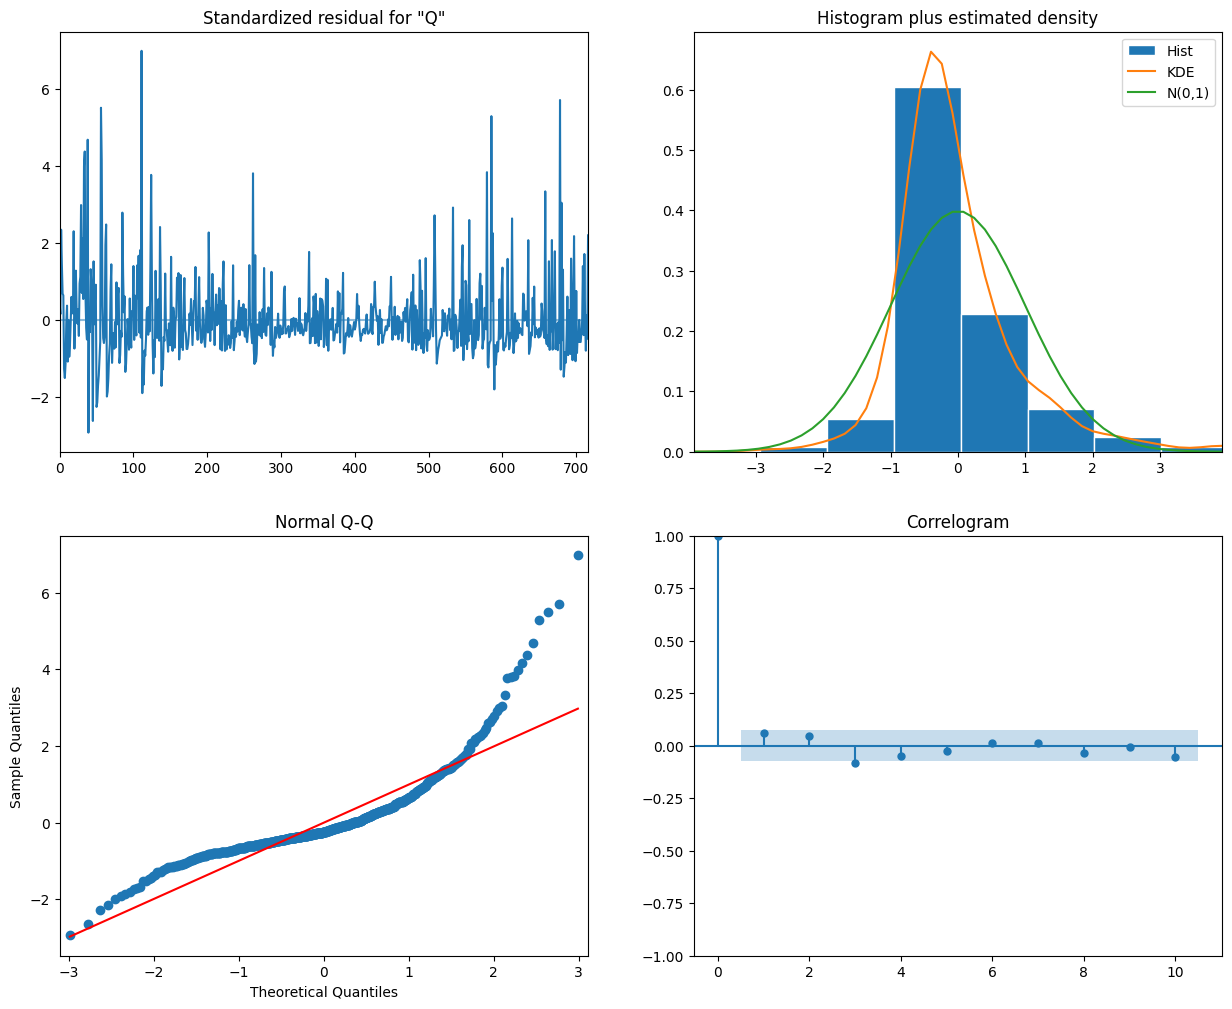

In [54]:
# Convert the index to datetime if it's not already
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index)

# Define the end date for the COVID period
covid_end = pd.to_datetime('2021-01-07')

# Filter the DataFrame to only include data after the COVID period
shampoo_daily_post_covid = shampoo_daily_df[shampoo_daily_df.index > covid_end]

# Since we are only using data after the COVID period, we don't need a Covid_Period dummy variable
# Now fit the ARIMA model on this filtered data
model_post_covid = ARIMA(shampoo_daily_post_covid['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  578
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4912.274
Date:                Thu, 07 Dec 2023   AIC                           9836.547
Time:                        12:12:43   BIC                           9862.705
Sample:                             0   HQIC                          9846.747
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1036.0337    170.411      6.080      0.000     702.034    1370.034
ar.L1          0.3091      0.340      0.908      0.364      -0.358       0.976
ar.L2          0.6261      0.332      1.885      0.0

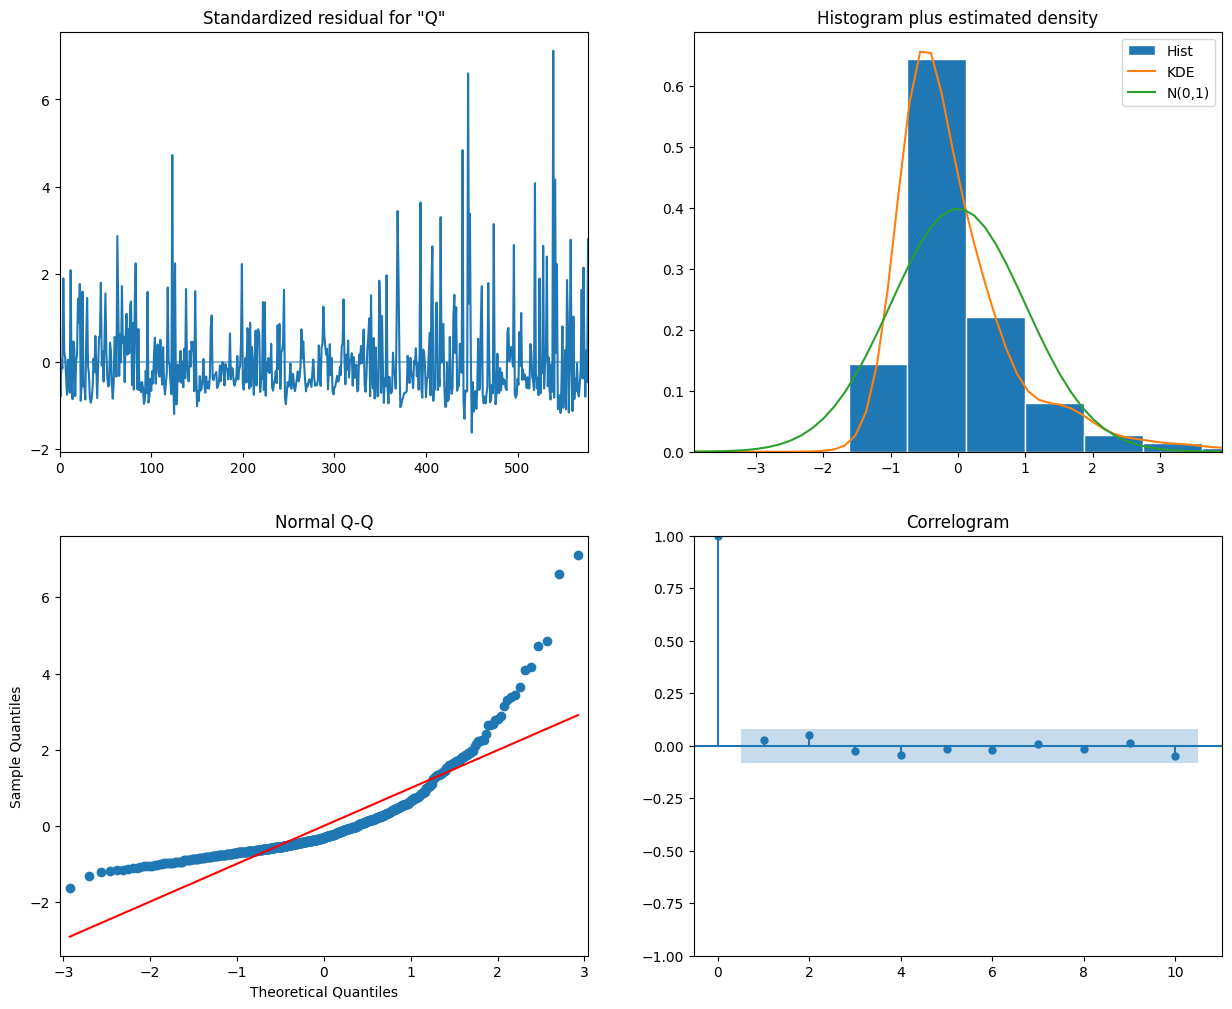

In [55]:
# Ensure the DataFrame index is of type DatetimeIndex
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index, errors='coerce')

# Now that we've ensured the index is datetime, filter out the COVID-19 period.
# We'll use the period after July 2021 for the ARIMA model fitting.
post_covid_data = shampoo_daily_df.loc[shampoo_daily_df.index > '2021-07-01']

# Make sure that 'QTY' is the correct column name for your sales data.
# Fit the ARIMA model using the post-COVID-19 data.
model_post_covid = ARIMA(post_covid_data['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model.
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model.
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


In [56]:
# Assuming you've already fitted your model: model_fit
# Assuming your DataFrame is shampoo_daily_df and the date index is already converted to datetime
shampoo_daily_df.index = pd.DatetimeIndex(shampoo_daily_df.index).to_period('D')

# Split data into train and test
train_data = shampoo_daily_df[shampoo_daily_df.index <= '2022-01-01']  # Example end of training period
test_data = shampoo_daily_df[shampoo_daily_df.index > '2022-01-01']   # Example start of testing period

# Fit the model on train_data
train_model = ARIMA(train_data['QTY'], order=(2, 0, 2))
train_model_fit = train_model.fit()

# Forecast on test_data
forecast = train_model_fit.forecast(steps=len(test_data))

# Compare the forecast to the actual values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['QTY'], forecast)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 1763.342


In [57]:
df.columns

Index(['Location', 'Brand', 'SubBrand', 'Category', 'SOP Number',
       'Item Number', 'Item Description', 'Old QTY', 'Unit Price',
       'Extended Price', 'Customer Number', 'Document Date', 'Item Short Name',
       'Customer Name', 'Location ID', 'Offer Status', 'product_type',
       'product_scent', 'product_size', 'Description Length', 'Subcategory',
       'With Offer', 'QTY'],
      dtype='object')

In [58]:
test_data['QTY'].mean()

952.9927400468384

In [59]:
df.to_csv("df_SF_Pre_LSTM.csv", index = False)

##LSTM Forecasting

In [123]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [124]:
import pandas as pd
import numpy as np
#Load data
#df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")

In [125]:
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the number of shampoos for each size
shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

print("Count of shampoos for each size:")
print(shampoo_counts_by_size)

Count of shampoos for each size:
1.125L    13366
2.25L     12880
4L        12733
3.0L       2800
6.0L       2343
4.0L        608
0nan        337
2.2L         68
0.008L       46
0.5L         31
2.0L         25
Name: product_size, dtype: int64


In [126]:
# # Assuming 'shampoo_daily' is your Pandas Series of summed 'QTY'
# shampoo_daily_df = shampoo_daily.to_frame(name='QTY')

# # Ensure that 'QTY' is numeric and has no missing values
# shampoo_daily_df['QTY'] = pd.to_numeric(shampoo_daily_df['QTY'], errors='coerce').fillna(0)

In [127]:
# shampoo_daily_df.columns

In [128]:
df.columns

Index(['Location', 'Brand', 'SubBrand', 'Category', 'SOP Number',
       'Item Number', 'Item Description', 'Old QTY', 'Unit Price',
       'Extended Price', 'Customer Number', 'Document Date', 'Item Short Name',
       'Customer Name', 'Location ID', 'Offer Status', 'product_type',
       'product_scent', 'product_size', 'Description Length', 'Subcategory',
       'With Offer', 'QTY'],
      dtype='object')

In [129]:
distinct_sizes = shampoo_df['product_size'].unique()

print("Distinct product sizes for 'shampoo':", distinct_sizes)

Distinct product sizes for 'shampoo': ['2.25L' '1.125L' '0.5L' '4L' '0nan' '6.0L' '3.0L' '0.008L' '4.0L' '2.0L'
 '2.2L']


In [130]:
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the number of shampoos for each size
shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

print("Count of shampoos for each size:")
print(shampoo_counts_by_size)

Count of shampoos for each size:
1.125L    13366
2.25L     12880
4L        12733
3.0L       2800
6.0L       2343
4.0L        608
0nan        337
2.2L         68
0.008L       46
0.5L         31
2.0L         25
Name: product_size, dtype: int64


In [131]:
brand_counts = df['product_type'].value_counts()

# Display the counts
print(brand_counts.head(10))

shampoo              45237
dishwashing          19617
laundry gel           7044
general cleaner       4677
hand soap             4397
disinfectant          3845
fabric softner        3149
multi-use shampoo     2838
floor cleaner         1955
shower gel            1557
Name: product_type, dtype: int64


In [132]:
import pandas as pd

# Assuming 'df' is already loaded and contains the relevant data
# Convert 'Document Date' to datetime if it's not already
df['Document Date'] = pd.to_datetime(df['Document Date'])

# Filter the dataframe for 'shampoo' product_type
shampoo_df = df[df['product_type'] == 'shampoo']

# Sort the dataframe by 'Document Date'
shampoo_df = shampoo_df.sort_values('Document Date')

# Group by 'Document Date' and sum the 'QTY'
daily_shampoo_sales = shampoo_df.groupby('Document Date')['QTY'].sum()

# Resample the data to get a regular daily time series
daily_shampoo_sales_resampled = daily_shampoo_sales.resample('M').asfreq().fillna(0)

# The resulting 'daily_shampoo_sales_resampled' will have dates as the index and the summed 'QTY' as the column
# If you want to reset the index so 'Document Date' becomes a column again, you can do so with the following line
daily_shampoo_sales_resampled = daily_shampoo_sales_resampled.reset_index()

# Display the first few entries of the regularized data
print(daily_shampoo_sales_resampled.head())

# You can then save this to a new CSV file for further use
daily_shampoo_sales_resampled.to_csv('regularized_shampoo_sales.csv', index=False)


  Document Date        QTY
0    2020-01-31  11645.125
1    2020-02-29   4907.625
2    2020-03-31  19912.875
3    2020-04-30  20436.000
4    2020-05-31      0.000


In [133]:
daily_shampoo_df = daily_shampoo_sales_resampled

In [134]:
# # print(shampoo_daily_df.index.freq)
# print(shampoo_daily_df.index.to_series().diff().unique())

In [135]:
# Define a function to detect outliers based on IQR
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return a boolean Series where True indicates the rows that are outliers
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Detect outliers in the 'QTY' column
outliers = detect_outliers(daily_shampoo_df, 'QTY')

# How many outliers are there?
print("Number of outliers:", outliers.sum())


Number of outliers: 3


In [136]:
# # Remove outliers
# daily_shampoo_df_no_outliers = daily_shampoo_df[~outliers]

# # Print the shape of the data before and after outlier removal for comparison
# print("Original shape:", daily_shampoo_df.shape)
# print("New shape after removing outliers:", daily_shampoo_df_no_outliers.shape)


In [137]:
split_date = pd.to_datetime('2022-01-01')

In [138]:
window_size = 3  # This can be tuned

# Apply a simple moving average
daily_shampoo_df['QTY_smoothed'] = daily_shampoo_df['QTY'].rolling(window=window_size).mean()

# Drop NaN values that result from the rolling function at the beginning of the series
daily_shampoo_df.dropna(inplace=True)


In [139]:
# Make sure 'Document Date' is datetime and set as index
daily_shampoo_df['Document Date'] = pd.to_datetime(daily_shampoo_df['Document Date'])
daily_shampoo_df.set_index('Document Date', inplace=True)

# Split into train and test sets
train_data = daily_shampoo_df[daily_shampoo_df.index < split_date]
test_data = daily_shampoo_df[daily_shampoo_df.index >= split_date]


In [140]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['QTY_smoothed']])
test_scaled = scaler.transform(test_data[['QTY_smoothed']])


In [141]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # You can adjust this based on how many previous steps you want to consider
X_train, Y_train = create_dataset(train_scaled, look_back)
X_test, Y_test = create_dataset(test_scaled, look_back)


In [142]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [143]:
model = Sequential()
model.add(LSTM(10, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [144]:
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
21/21 - 3s - loss: 0.1473 - 3s/epoch - 138ms/step
Epoch 2/100
21/21 - 0s - loss: 0.1229 - 62ms/epoch - 3ms/step
Epoch 3/100
21/21 - 0s - loss: 0.1017 - 62ms/epoch - 3ms/step
Epoch 4/100
21/21 - 0s - loss: 0.0859 - 60ms/epoch - 3ms/step
Epoch 5/100
21/21 - 0s - loss: 0.0742 - 65ms/epoch - 3ms/step
Epoch 6/100
21/21 - 0s - loss: 0.0643 - 72ms/epoch - 3ms/step
Epoch 7/100
21/21 - 0s - loss: 0.0583 - 60ms/epoch - 3ms/step
Epoch 8/100
21/21 - 0s - loss: 0.0536 - 65ms/epoch - 3ms/step
Epoch 9/100
21/21 - 0s - loss: 0.0501 - 65ms/epoch - 3ms/step
Epoch 10/100
21/21 - 0s - loss: 0.0485 - 68ms/epoch - 3ms/step
Epoch 11/100
21/21 - 0s - loss: 0.0470 - 65ms/epoch - 3ms/step
Epoch 12/100
21/21 - 0s - loss: 0.0455 - 63ms/epoch - 3ms/step
Epoch 13/100
21/21 - 0s - loss: 0.0447 - 61ms/epoch - 3ms/step
Epoch 14/100
21/21 - 0s - loss: 0.0440 - 59ms/epoch - 3ms/step
Epoch 15/100
21/21 - 0s - loss: 0.0433 - 64ms/epoch - 3ms/step
Epoch 16/100
21/21 - 0s - loss: 0.0444 - 64ms/epoch - 3ms/step
E

In [145]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [146]:
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))


In [147]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam
# import numpy as np
# from sklearn.metrics import mean_squared_error

# # # Function to create dataset remains the same
# # def create_dataset(dataset, look_back=1):
# #     # Your existing function code
# #     # ...
# def create_dataset(dataset, look_back=1):
#     X, Y = [], []
#     for i in range(len(dataset) - look_back):
#         a = dataset[i:(i + look_back), 0]
#         X.append(a)
#         Y.append(dataset[i + look_back, 0])
#     return np.array(X), np.array(Y)

# scaler = MinMaxScaler(feature_range=(0, 1))
# train_scaled = scaler.fit_transform(train_data[['QTY_smoothed']])
# test_scaled = scaler.transform(test_data[['QTY_smoothed']])


# # Prepare the dataset for training
# look_back = 3  # Increased look_back to consider more past steps
# X_train, Y_train = create_dataset(train_scaled, look_back)
# X_test, Y_test = create_dataset(test_scaled, look_back)

# # Reshape input for LSTM [samples, time steps, features]
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(100, return_sequences=True, input_shape=(look_back, 1)))  # Increased number of neurons and added return_sequences for stacking
# model.add(Dropout(0.2))  # Added dropout for regularization
# model.add(LSTM(50, return_sequences=False))  # Additional LSTM layer
# model.add(Dense(1))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Adjusted learning rate

# # Fit the model
# model.fit(X_train, Y_train, epochs=150, batch_size=32, verbose=2)  # Adjusted epochs and batch size

# # Predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Inverse transform predictions and actual values to original scale
# train_predict = scaler.inverse_transform(train_predict)
# Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))
# test_predict = scaler.inverse_transform(test_predict)
# Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# # Calculate RMSE for LSTM predictions
# lstm_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))
# print(f'LSTM Test RMSE: {lstm_rmse:.3f}')


In [148]:
lstm_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))
print(f'LSTM Test RMSE: {lstm_rmse:.3f}')


LSTM Test RMSE: 1089.368


In [149]:
# Calculate the mean of the original sales data
mean_original_data = daily_shampoo_df['QTY'].mean()
print(f'Mean of Original Sales Data: {mean_original_data:.3f}')

Mean of Original Sales Data: 3786.406


In [150]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV


In [151]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from keras.wrappers.scikit_learn import KerasRegressor

# def build_model(optimizer='adam', neurons=50):
#     model = Sequential()
#     model.add(LSTM(neurons, input_shape=(look_back, 1)))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model


In [153]:
# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
